In [46]:
# libraries
import pandas as pd
import os
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline


In [47]:
dir = os.getcwd()
file_path = os.path.join(dir,"DataSets-main" )
cab_df = pd.read_csv(file_path + "/Cab_Data.csv")
city_df = pd.read_csv(file_path + "/City.csv")
customer_df = pd.read_csv(file_path + "/Customer_ID.csv")
transaction_df = pd.read_csv(file_path + "/Transaction_ID.csv")

# change the date format to a more readable format
cab_df['Date of Travel'] = pd.to_datetime(cab_df['Date of Travel'], origin='1899-12-30', unit='D')

In [48]:
# Get information of the cab dataframe
cab_df.info()
# Percentage of missing values
print("Percentage of missing values")
cab_df.isnull().sum()/ len(cab_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359392 entries, 0 to 359391
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Transaction ID  359392 non-null  int64         
 1   Date of Travel  359392 non-null  datetime64[ns]
 2   Company         359392 non-null  object        
 3   City            359392 non-null  object        
 4   KM Travelled    359392 non-null  float64       
 5   Price Charged   359392 non-null  float64       
 6   Cost of Trip    359392 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 19.2+ MB
Percentage of missing values


Transaction ID    0.0
Date of Travel    0.0
Company           0.0
City              0.0
KM Travelled      0.0
Price Charged     0.0
Cost of Trip      0.0
dtype: float64

In [49]:
city_df.head()


,City,Population,Users
0,NEW YORK NY,"8,405,837","302,149"
1,CHICAGO IL,"1,955,130","164,468"
2,LOS ANGELES CA,"1,595,037","144,132"
3,MIAMI FL,"1,339,155","17,675"
4,SILICON VALLEY,"1,177,609","27,247"


In [50]:
city_df.info()

#Checking for null values
city_df.isna().sum() / len(city_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   City        20 non-null     object
 1   Population  20 non-null     object
 2   Users       20 non-null     object
dtypes: object(3)
memory usage: 612.0+ bytes


City          0.0
Population    0.0
Users         0.0
dtype: float64

In [51]:
customer_df.head()


,Customer ID,Gender,Age,Income (USD/Month)
0,29290,Male,28,10813
1,27703,Male,27,9237
2,28712,Male,53,11242
3,28020,Male,23,23327
4,27182,Male,33,8536


In [52]:
customer_df.info()

customer_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49171 entries, 0 to 49170
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Customer ID         49171 non-null  int64 
 1   Gender              49171 non-null  object
 2   Age                 49171 non-null  int64 
 3   Income (USD/Month)  49171 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


Customer ID           0
Gender                0
Age                   0
Income (USD/Month)    0
dtype: int64

In [53]:
transaction_df.head()

,Transaction ID,Customer ID,Payment_Mode
0,10000011,29290,Card
1,10000012,27703,Card
2,10000013,28712,Cash
3,10000014,28020,Cash
4,10000015,27182,Card


In [54]:
transaction_df.info()

transaction_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440098 entries, 0 to 440097
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Transaction ID  440098 non-null  int64 
 1   Customer ID     440098 non-null  int64 
 2   Payment_Mode    440098 non-null  object
dtypes: int64(2), object(1)
memory usage: 10.1+ MB


Transaction ID    0
Customer ID       0
Payment_Mode      0
dtype: int64

## Combining the datasets to one dataframe

In [55]:
# Customer information
customer_info = pd.merge(customer_df, transaction_df)
customer_info.head()


,Customer ID,Gender,Age,Income (USD/Month),Transaction ID,Payment_Mode
0,29290,Male,28,10813,10000011,Card
1,29290,Male,28,10813,10351127,Cash
2,29290,Male,28,10813,10412921,Card
3,27703,Male,27,9237,10000012,Card
4,27703,Male,27,9237,10320494,Card


In [56]:
# Cab information
cab_info = pd.merge(cab_df, city_df)
cab_info.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Population,Users
0,10000011,2016-01-08,Pink Cab,ATLANTA GA,30.45,370.95,313.635,"814,885","24,701"
1,10000012,2016-01-06,Pink Cab,ATLANTA GA,28.62,358.52,334.854,"814,885","24,701"
2,10000013,2016-01-02,Pink Cab,ATLANTA GA,9.04,125.20,97.632,"814,885","24,701"
3,10000014,2016-01-07,Pink Cab,ATLANTA GA,33.17,377.40,351.602,"814,885","24,701"
4,10000015,2016-01-03,Pink Cab,ATLANTA GA,8.73,114.62,97.776,"814,885","24,701"


In [58]:
#print the shapes of the initial dataframes
print(f"Shape for cab: {cab_df.shape}, customer : {customer_df.shape}, City: {city_df.shape}, transaction: {transaction_df.shape}")

Shape for cab: (359392, 7), customer : (49171, 4), City: (20, 3), transaction: (440098, 3)


### Encoding categorical columns

In [60]:
# Select the columns to be encoded
target_columns = customer_info[['Gender', 'Payment_Mode']]

# Perform label encoding
label_encoder = LabelEncoder()
label_encoded = target_columns.apply(label_encoder.fit_transform)

# Perform one-hot encoding
one_hot_encoder = OneHotEncoder()
one_hot_encoded = one_hot_encoder.fit_transform(label_encoded)

# Get the feature names
encoded_feature_names = []
for col in target_columns.columns:
    # Getting the unique categorical values in the target columns
    unique_values = target_columns[col].unique()
    for value in unique_values:
        encoded_feature_names.append(f"{col}_{value}")

# create a dataframe of the one-hot encoded columns
one_hot_encoded_df = pd.DataFrame(one_hot_encoded.toarray(), columns=encoded_feature_names)

# Concatenate the customer dataframe with the one-hot encoded columns
customer_info_encoded = pd.concat([customer_info.drop(target_columns, axis=1), one_hot_encoded_df], axis=1)

one_hot_encoded_df.head()


,Gender_Male,Gender_Female,Payment_Mode_Card,Payment_Mode_Cash
0,0.0,1.0,1.0,0.0
1,0.0,1.0,0.0,1.0
2,0.0,1.0,1.0,0.0
3,0.0,1.0,1.0,0.0
4,0.0,1.0,1.0,0.0


## Understanding the relationships between the data

In [61]:
# combined data ---> Actionable data. It contains data of customers that have used the cab between 31/01/2016 to 31/12/2018
combined_df = customer_info_encoded.merge(cab_info, on='Transaction ID')
combined_df.head()

,Customer ID,Age,Income (USD/Month),Transaction ID,Gender_Male,Gender_Female,Payment_Mode_Card,Payment_Mode_Cash,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Population,Users
0,29290,28,10813,10000011,0.0,1.0,1.0,0.0,2016-01-08,Pink Cab,ATLANTA GA,30.45,370.95,313.6350,"814,885","24,701"
1,29290,28,10813,10351127,0.0,1.0,0.0,1.0,2018-07-21,Yellow Cab,ATLANTA GA,26.19,598.70,317.4228,"814,885","24,701"
2,29290,28,10813,10412921,0.0,1.0,1.0,0.0,2018-11-23,Yellow Cab,ATLANTA GA,42.55,792.05,597.4020,"814,885","24,701"
3,27703,27,9237,10000012,0.0,1.0,1.0,0.0,2016-01-06,Pink Cab,ATLANTA GA,28.62,358.52,334.8540,"814,885","24,701"
4,27703,27,9237,10320494,0.0,1.0,1.0,0.0,2018-04-21,Yellow Cab,ATLANTA GA,36.38,721.10,467.1192,"814,885","24,701"


### 1. Market share for each company
   -  It shows the level of acceptance or popularity of the cabs in the market.
   - The market share of each company is calculated by comparing the total number of trips made by each company to the total number of trips in the market

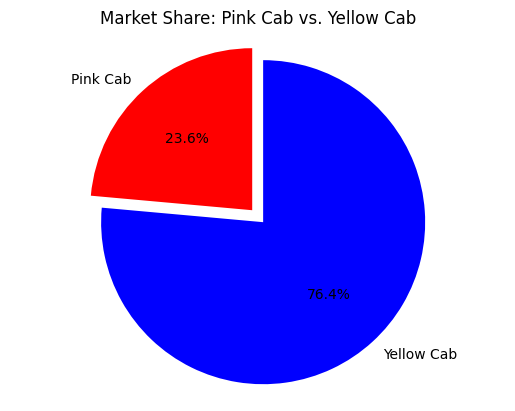

In [63]:
# Filter the dataframe based on Company
pink_cab_df = combined_df[(combined_df['Company'] == 'Pink Cab')]
yellow_cab_df = combined_df[(combined_df['Company'] == 'Yellow Cab')]

# Total number of trips for each company
pink_cab_trips = pink_cab_df.shape[0]
yellow_cab_trips = yellow_cab_df.shape[0]

# Total number of trips in the market
total_trips = combined_df.shape[0]

# Market share for each company
pink_cab_market_share = pink_cab_trips / total_trips * 100
yellow_cab_market_share = yellow_cab_trips / total_trips * 100

# Pie chart to visualize the market share
labels = ['Pink Cab', 'Yellow Cab']
sizes = [pink_cab_market_share, yellow_cab_market_share]
colors = ['r', 'b']
explode = (0.1, 0)

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Market Share: Pink Cab vs. Yellow Cab')
plt.show()

### 13. Customer Retention
   -  Customer retention is crucial for the long-term success of a cab company.

Retention Rates for Year 2016:
Pink Cab: 46.28%
Yellow Cab: 26.37%

Retention Rates for Year 2017:
Pink Cab: 52.46%
Yellow Cab: 35.56%



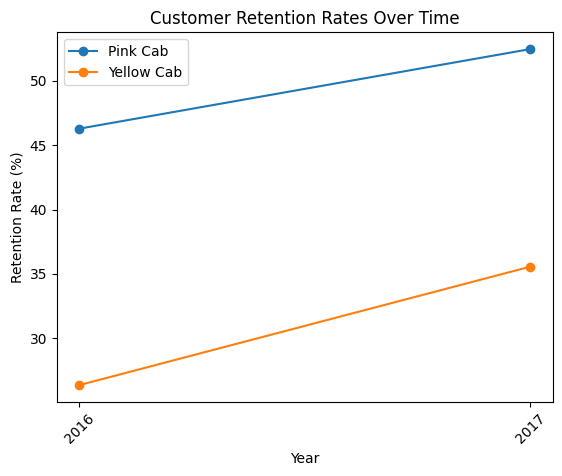

In [82]:
# Determine the time frames within the specified time period
start_date = '2016-01-31'
end_date = '2018-12-31'
time_frames = pd.date_range(start=start_date, end=end_date, freq='Y')

# Calculate the customer retention rate for each company for each time frame
retention_rates_pink_cab = []
retention_rates_yellow_cab = []

for i in range(len(time_frames) - 1):
    start_date = time_frames[i].strftime('%Y-%m-%d')
    end_date = time_frames[i+1].strftime('%Y-%m-%d')

    #determine the start amd end customers of tje pink cab
    pink_cab_start_customers = len(pink_cab_df[pink_cab_df['Date of Travel'] <= start_date]['Customer ID'].unique())
    pink_cab_end_customers = len(pink_cab_df[pink_cab_df['Date of Travel'] <= end_date]['Customer ID'].unique())

    # determine the new customers throughout the year
    pink_cab_new_customers = len(pink_cab_df[(pink_cab_df['Date of Travel'] >= start_date) & (pink_cab_df['Date of Travel'] <= end_date)]['Customer ID'].unique())

    # determine the start and end customers pf tje pink cab
    yellow_cab_start_customers = len(yellow_cab_df[yellow_cab_df['Date of Travel'] <= start_date]['Customer ID'].unique())
    yellow_cab_end_customers = len(yellow_cab_df[yellow_cab_df['Date of Travel'] <= end_date]['Customer ID'].unique())

    # determine the new customers throughout the year
    yellow_cab_new_customers = len(yellow_cab_df[(yellow_cab_df['Date of Travel'] >= start_date) & (yellow_cab_df['Date of Travel'] <= end_date)]['Customer ID'].unique())

    # calculating the retention rate
    pink_cab_retention_rate = (pink_cab_end_customers - pink_cab_new_customers) / pink_cab_start_customers * 100
    yellow_cab_retention_rate = (yellow_cab_end_customers - yellow_cab_new_customers) / yellow_cab_start_customers * 100

    retention_rates_pink_cab.append(pink_cab_retention_rate)
    retention_rates_yellow_cab.append(yellow_cab_retention_rate)


for i in range(len(time_frames) - 1):
    year = time_frames[i].year
    pink_cab_rate = retention_rates_pink_cab[i]
    yellow_cab_rate = retention_rates_yellow_cab[i]

    print(f"Retention Rates for Year {year}:")
    print("Pink Cab: {:.2f}%".format(pink_cab_rate))
    print("Yellow Cab: {:.2f}%".format(yellow_cab_rate))
    print()

# Plotting retention rates for Pink Cab
plt.plot(time_frames[:-1], retention_rates_pink_cab, marker='o', label='Pink Cab')

# Plotting retention rates for Yellow Cab
plt.plot(time_frames[:-1], retention_rates_yellow_cab, marker='o', label='Yellow Cab')

# Set title and labels
plt.title('Customer Retention Rates Over Time')
plt.xlabel('Year')
plt.ylabel('Retention Rate (%)')

# Set x-axis tick labels
plt.xticks(time_frames[:-1], [str(year) for year in time_frames[:-1].year], rotation=45)

# Add legend
plt.legend()

# Display the plot
plt.show()

## 3. Customer Segmentation

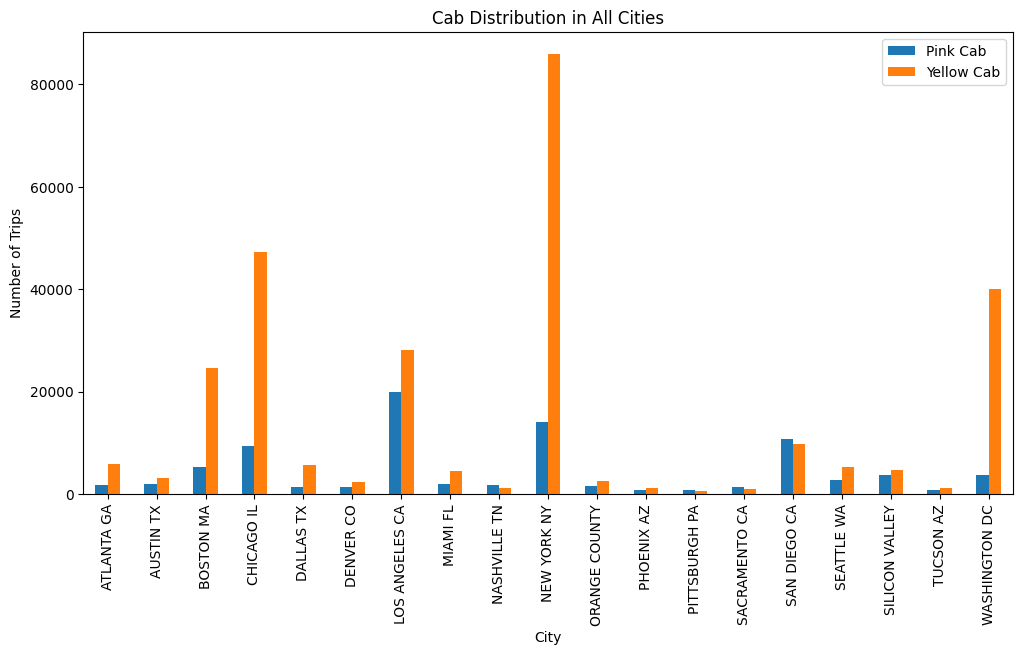

In [115]:
cab_distribution = combined_df.groupby(['City', 'Company']).size().unstack(level=1)

# Stacked bar graph for cab distribution in all cities
cab_distribution.plot(kind='bar', figsize=(12, 6))
plt.xlabel('City')
plt.ylabel('Number of Trips')
plt.title('Cab Distribution in All Cities')
plt.legend()
plt.show()


* Determining customer preference based on gender, payment methods and age

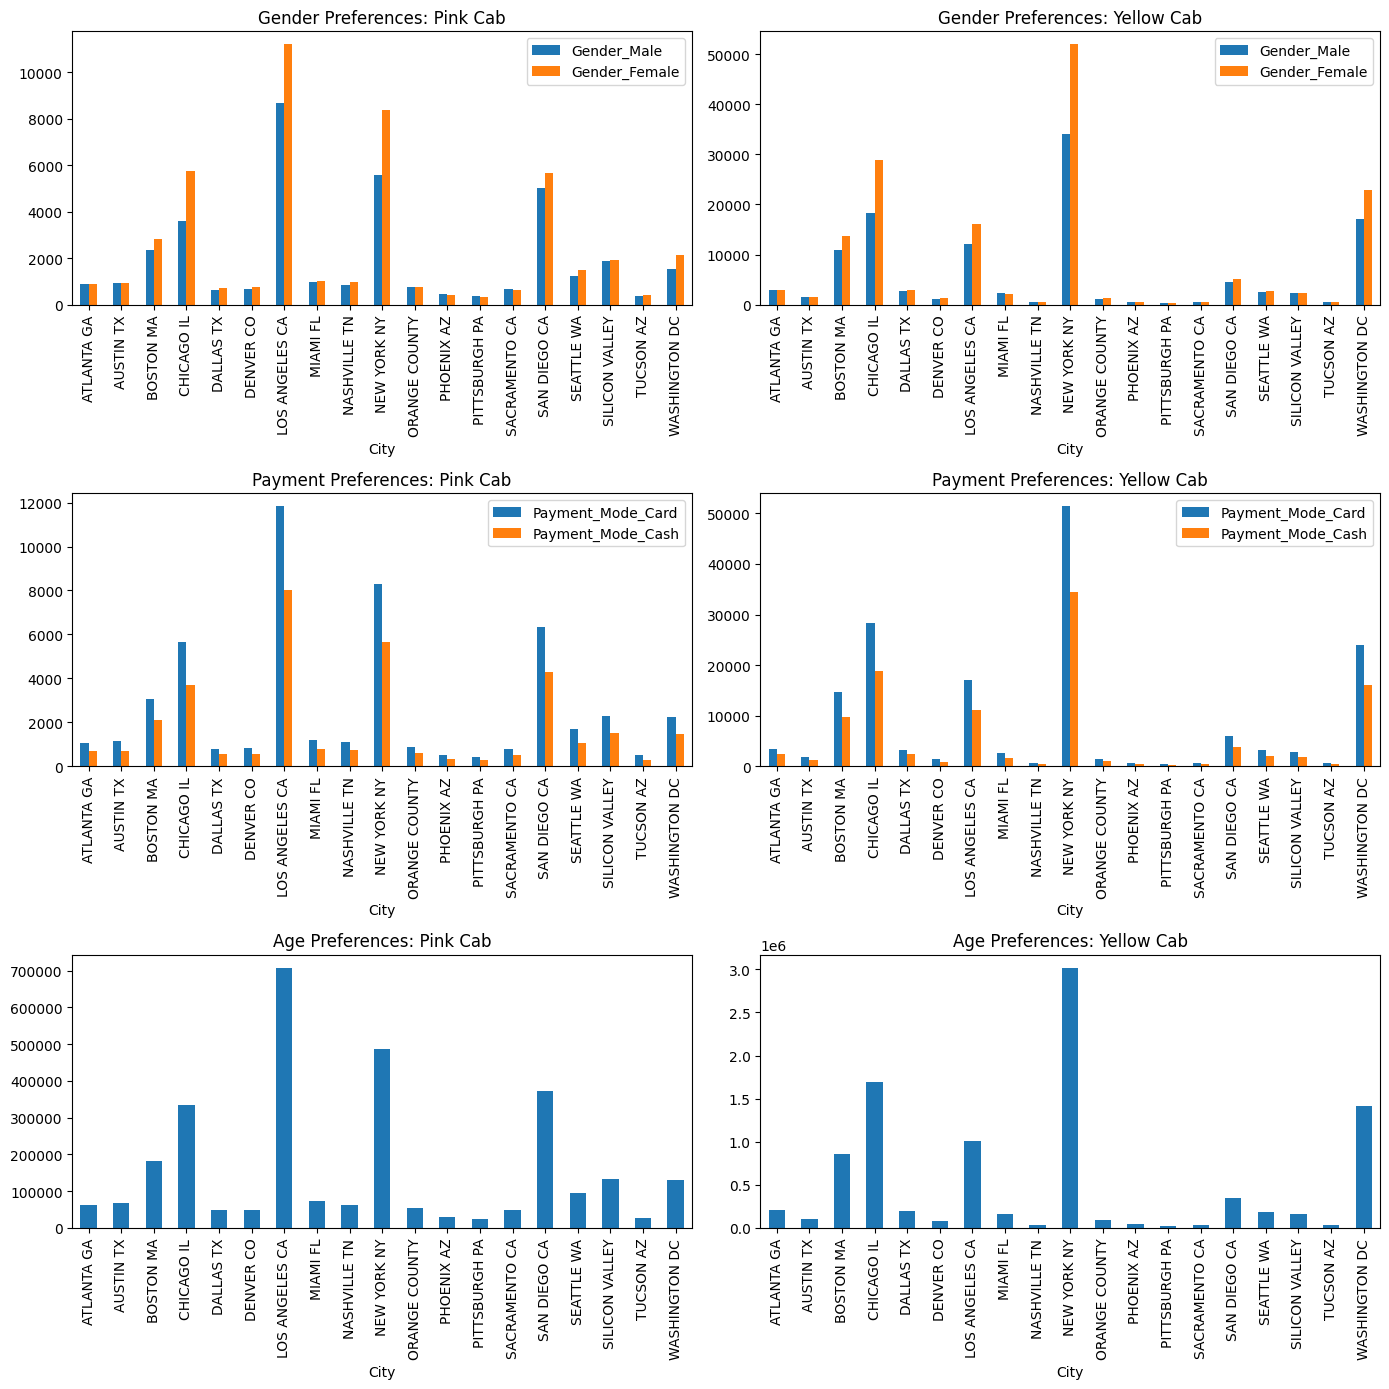

In [118]:
# Define the factors to consider for customer preferences
gender_factors = ['Gender_Male', 'Gender_Female']
payment_factors = ['Payment_Mode_Card', 'Payment_Mode_Cash']
age_factor = 'Age'

# Customer preferences for each factor and cab company
pink_cab_preferences = pink_cab_df.groupby('City')[gender_factors + payment_factors + [age_factor]].sum()
yellow_cab_preferences = yellow_cab_df.groupby('City')[gender_factors + payment_factors + [age_factor]].sum()

# Creating separate graphs for gender preferences, payment preferences, and age preferences for each cab company
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 14))

# Gender Preferences
pink_cab_preferences[gender_factors].plot(kind='bar', ax=axes[0, 0], title='Gender Preferences: Pink Cab')
yellow_cab_preferences[gender_factors].plot(kind='bar', ax=axes[0, 1], title='Gender Preferences: Yellow Cab')

# Payment Preferences
pink_cab_preferences[payment_factors].plot(kind='bar', ax=axes[1, 0], title='Payment Preferences: Pink Cab')
yellow_cab_preferences[payment_factors].plot(kind='bar', ax=axes[1, 1], title='Payment Preferences: Yellow Cab')

# Age Preferences
pink_cab_preferences[age_factor].plot(kind='bar', ax=axes[2, 0], title='Age Preferences: Pink Cab')
yellow_cab_preferences[age_factor].plot(kind='bar', ax=axes[2, 1], title='Age Preferences: Yellow Cab')

# Adjust the layout and spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()
